<a href="https://colab.research.google.com/github/DataDoggo215/Flatiron_Capstone/blob/main/capstone_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A.I. Opening Approach to Diabetic Retinopathy

A link to a video of the project presentation can be found at: https://drive.google.com/file/d/1G-ox92HOPGuWcFxHaJoX4rixzEYIvfuF/view?usp=sharing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras import datasets, layers, models
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import os, shutil

from PIL import Image
import PIL

random_state = 112221

In [ ]:
#Mount to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#check google GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Business Understanding

The World Health Organization estiamtes that over 420 million people worldwide have diaebetes with the number of cases and prevalance of disease increasing worldwide each year. The majority of these cases occur in low to middle income countries where resources are low. Early detection of this disease and it's complications can reduce health burdens worlwide.

![stats](https://drive.google.com/uc?export=view&id=1Fk7ZeOdBUTG20Jcp8NbQ_u8OkugnP46b)

One major complication of Diabetes, and that can readily be screened, is Diabetic Retinopathy, one of the leading causes of blindness. 

![DR](https://drive.google.com/uc?export=view&id=1oT9eMRUosdkOqC11pIvIe4p9x8AzeKI-)






Currently, detecting DR is a time-consuming and manual process that requires bulky devices to take pictures for trained clinicians to examine and evaluate digital color fundus photographs of the retina. By the time human readers submit their reviews, often a day or two later, the delayed results lead to lost follow up, miscommunication, and delayed treatment. While this approach is effective, its resource demands are high. The expertise and equipment required are often lacking in areas where the rate of diabetes in local populations is high and DR detection is most needed. 


One promising technique that has shown promising results in the literature is smartphone fundus photography. 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5609317/

![phone](https://drive.google.com/uc?export=view&id=1OoIZMddl7CFgmVOiy4-YM3Q3SV3zvODY)

![phone](https://drive.google.com/uc?export=view&id=1YHKxvpsoyj7Oo8Tum-9Rgbr9vz2m5KL4)


Using powerful smartphone imaging equipped with a portable lens partnered up with machine learning to detect DR can make health screening more accessible and get help to those who needs it the most.

#Data

The data set comes a kaggle competition that can be found here: 
https://www.kaggle.com/competitions/diabetic-retinopathy-detection/overview

The file contains 90 gigabites of images seperated into train set with labels and a test set without the labels. The labels are categorized as 0 (No DR) to 4 (Different severity of DR). Since this is not for the competition, the test set with no labels will be excluded. The training set will then be split to our own test, train, and validation set. Additionally, the problem will be set to a binary classification problem: 0 (No DR), 1 (DR present).

## EDA

In [ ]:
#Upload and examine the train labels
train_labels = pd.read_csv('/content/gdrive/My Drive/Flatiron/trainLabels.csv')
train_labels

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


We see that the labels have the image name attached, but not the images itself. We can fix this by adding .jpeg file extension to the names. For our intended use case, we are also only interested if the patient has the disease or not. We can make this a binary classification problem.

In [ ]:
#Add image extensions
train_labels['image'] = train_labels['image'] + '.jpeg'
#Binary Classification
train_labels['level'].replace([1,2,3,4], 1, inplace = True)
train_labels['level'] = train_labels['level'].astype('str')

In [ ]:
train_labels

,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1
...,...,...
35121,44347_right.jpeg,0
35122,44348_left.jpeg,0
35123,44348_right.jpeg,0
35124,44349_left.jpeg,0


##Train/Test Split

The Dataset contains 35126 images. We will split the dataset first into a test and train split and then perform another split to keep a set for validation. The split of 10% was chosen because there are enough images to make a sizable test and validation sample at that threshold. 

In [ ]:
initial_train_sp, test_sp = train_test_split(train_labels, test_size=.1, stratify= train_labels['level'], random_state=random_state)

In [ ]:
train_sp, val_sp = train_test_split(initial_train_sp, test_size=.1, stratify= initial_train_sp['level'], random_state=random_state)

In [ ]:
test_reshaped = np.array(test_sp['level']).reshape(-1,1).astype(int)
test_reshaped

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

##Making Directories

In [ ]:
data_dir = '/content/gdrive/My Drive/Flatiron/kaggle_train'

In [ ]:
local_dataset_imgs_names = [file for file in os.listdir(data_dir)]
local_dataset_imgs_names[30000:30010]

['14702_left.jpeg',
 '1469_left.jpeg',
 '14698_left.jpeg',
 '1469_right.jpeg',
 '14698_right.jpeg',
 '14702_right.jpeg',
 '14712_left.jpeg',
 '14711_left.jpeg',
 '14711_right.jpeg',
 '14710_right.jpeg']

In [ ]:
print('There are', len(local_dataset_imgs_names), 'eye images.')

There are 35126 eye images.


In [ ]:
train_labels['level'].value_counts()

0    25810
1     9316
Name: level, dtype: int64

In [ ]:
local_split_dir = '/content/gdrive/My Drive/Flatiron/split'


train_folder = os.path.join(local_split_dir, 'train')
val_folder = os.path.join(local_split_dir, 'validation')
test_folder = os.path.join(local_split_dir, 'test')


In [ ]:
train_norm_dir = os.path.join(train_folder, '0')
train_positive_dir = os.path.join(train_folder, '1')

There is a bit of a class imbalance, so we will set different weights to adjust for this.

In [ ]:
normal= len(os.listdir(train_norm_dir))
positive= len(os.listdir(train_positive_dir))

train_count = normal + positive
weight_for_0 = (1 / normal) * (train_count) / 2.0
weight_for_1 = (1 / positive) * (train_count) / 2.0

weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.89


In [ ]:
#Make Directories, Only enter this once.
#os.mkdir(train_folder)
#os.mkdir(val_folder)
#os.mkdir(test_folder)

In [ ]:
#make sub directories, Only enter this once.
#for class_name in train_labels['level'].unique():
 #    for folder in ['train', 'validation', 'test']:
  #       os.mkdir(os.path.join('/content/gdrive/My Drive/Flatiron/split/', folder, class_name))


In [ ]:
img_dfs = [train_sp, val_sp, test_sp]
img_names_prezip = [list(df['image'].values) for df in img_dfs]
img_names = list(zip([('train'), ('validation'), ('test')], img_names_prezip))

In [ ]:
# Only enter this once
# for folder, img_list in img_names:
#      for image in img_list:
#         class_name = train_labels[train_labels['image'] == image]['level'].values[0]
#         origin = os.path.join(data_dir, image)
#         destination = os.path.join('/content/gdrive/My Drive/Flatiron/split/', folder, class_name, image)
#         shutil.copyfile(origin, destination)

# Modeling


In [ ]:
image_size = (256,256)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_folder,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder,
    image_size=image_size,
    batch_size=batch_size,
)


Found 28451 files belonging to 2 classes.
Found 3162 files belonging to 2 classes.
Found 3513 files belonging to 2 classes.


In [ ]:
#Create a layer for data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:
#autotune and prefetch is applied here for better optimization
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

We will try to build different models while hypertuning them to see their performance. The first model is a very basic CNN, while the other ones were tranferred learning.

## Basic CNN

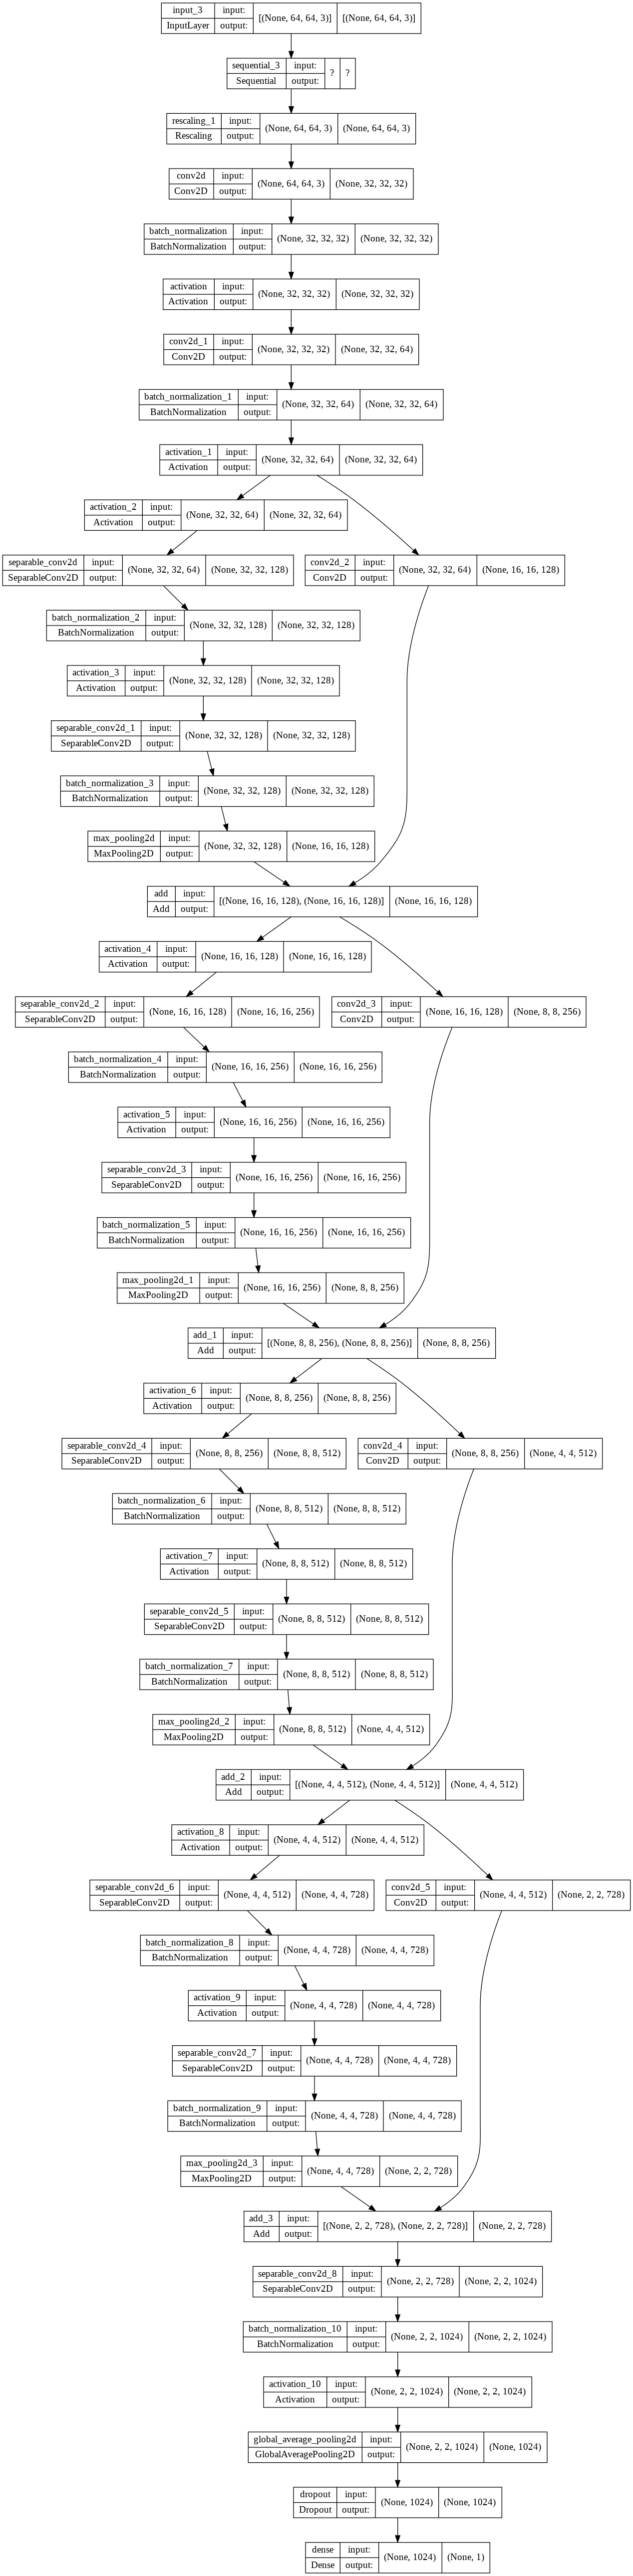

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential_3 (Sequential)      multiple             0           ['input_3[0][0]']                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 64, 64, 3)    0           ['sequential_3[0][0]']           
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['rescaling_1[0][0]']            
                                                                                              

In [ ]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Flatiron/models/first_model.hdf5'),
]
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/30
890/890 [==============================] - 1183s 1s/step - loss: 0.5971 - accuracy: 0.7231 - val_loss: 0.5740 - val_accuracy: 0.7347
Epoch 2/30
890/890 [==============================] - 17s 19ms/step - loss: 0.5782 - accuracy: 0.7340 - val_loss: 0.5895 - val_accuracy: 0.7347
Epoch 3/30
890/890 [==============================] - 17s 19ms/step - loss: 0.5704 - accuracy: 0.7345 - val_loss: 0.6032 - val_accuracy: 0.7347
Epoch 4/30
890/890 [==============================] - 17s 19ms/step - loss: 0.5664 - accuracy: 0.7340 - val_loss: 0.5977 - val_accuracy: 0.7350
Epoch 5/30
890/890 [==============================] - 17s 19ms/step - loss: 0.5606 - accuracy: 0.7356 - val_loss: 0.6134 - val_accuracy: 0.7347
Epoch 6/30
890/890 [==============================] - 17s 19ms/step - loss: 0.5573 - accuracy: 0.7361 - val_loss: 0.5861 - val_accuracy: 0.7350
Epoch 7/30
890/890 [==============================] - 17s 19ms/step - loss: 0.5534 - accuracy: 0.7394 - val_loss: 0.5685 - val_accuracy:

In [ ]:
#load_file = '/content/gdrive/My Drive/Flatiron/models/first_model.hdf5'
#tuned_model = load_model(load_file)
model.evaluate(test_ds)

110/110 [==============================] - 113s 951ms/step - loss: 1.3972 - accuracy: 0.6738


[1.3971551656723022, 0.6737830638885498]

##Transfer Learning - Xception

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

In [ ]:
# Create new model on top
inputs = keras.Input(shape=(256, 256, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = data_augmentation(inputs)

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 255)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation= 'sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [ ]:
epochs = 20
filepath = '/content/gdrive/My Drive/Flatiron/models/Xception_ensemble.hdf5'

callbacks = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,class_weight=weight,
)

Epoch 1/20
890/890 [==============================] - ETA: 0s - loss: 0.6739 - binary_accuracy: 0.5873
Epoch 1: val_loss improved from inf to 0.67332, saving model to /content/gdrive/My Drive/Flatiron/models/Xception_ensemble.hdf5
890/890 [==============================] - 1314s 1s/step - loss: 0.6739 - binary_accuracy: 0.5873 - val_loss: 0.6733 - val_binary_accuracy: 0.5803
Epoch 2/20
889/890 [============================>.] - ETA: 0s - loss: 0.6573 - binary_accuracy: 0.6177
Epoch 2: val_loss did not improve from 0.67332
890/890 [==============================] - 102s 114ms/step - loss: 0.6573 - binary_accuracy: 0.6177 - val_loss: 0.6868 - val_binary_accuracy: 0.5614
Epoch 3/20
889/890 [============================>.] - ETA: 0s - loss: 0.6531 - binary_accuracy: 0.6210
Epoch 3: val_loss improved from 0.67332 to 0.64776, saving model to /content/gdrive/My Drive/Flatiron/models/Xception_ensemble.hdf5
890/890 [==============================] - 101s 113ms/step - loss: 0.6531 - binary_accur

In [ ]:
base_model.trainable = True
model.summary()

epochs = 20

filepath = '/content/gdrive/My Drive/Flatiron/models/Xception_ensemble_tuned.hdf5'

callbacks = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds, class_weight=weight,
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [ ]:
load_file = filepath
base_model = load_model(load_file)
#base_model.evaluate(test_ds)

##Transfer Learning - DenseNet201

In [ ]:
base_model = keras.applications.DenseNet201(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

In [ ]:
# Create new model on top
inputs = keras.Input(shape=(256, 256, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = data_augmentation(inputs)

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 255)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation= 'sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d_3   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1920)              0         
                                                           

In [ ]:
epochs = 20
filepath = '/content/gdrive/My Drive/Flatiron/models/densenet_ensemble.hdf5'

callbacks = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,class_weight=weight,
)

Epoch 1/20
890/890 [==============================] - ETA: 0s - loss: 0.6787 - binary_accuracy: 0.5825
Epoch 1: val_loss improved from inf to 0.60541, saving model to /content/gdrive/My Drive/Flatiron/models/densenet_ensemble.hdf5
890/890 [==============================] - 2524s 3s/step - loss: 0.6787 - binary_accuracy: 0.5825 - val_loss: 0.6054 - val_binary_accuracy: 0.6888
Epoch 2/20
889/890 [============================>.] - ETA: 0s - loss: 0.6557 - binary_accuracy: 0.6179
Epoch 2: val_loss did not improve from 0.60541
890/890 [==============================] - 111s 125ms/step - loss: 0.6557 - binary_accuracy: 0.6179 - val_loss: 0.6233 - val_binary_accuracy: 0.6635
Epoch 3/20
889/890 [============================>.] - ETA: 0s - loss: 0.6488 - binary_accuracy: 0.6296
Epoch 3: val_loss improved from 0.60541 to 0.59673, saving model to /content/gdrive/My Drive/Flatiron/models/densenet_ensemble.hdf5
890/890 [==============================] - 111s 125ms/step - loss: 0.6488 - binary_accur

In [ ]:
base_model.trainable = True
model.summary()

epochs = 20

filepath = '/content/gdrive/My Drive/Flatiron/models/densenet_ensemble_tuned.hdf5'

callbacks = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds, class_weight=weight,
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d_3   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1920)              0         
                                                           

In [ ]:
load_file = '/content/gdrive/My Drive/Flatiron/models/densenet_ensemble_tuned.hdf5'
base_model = load_model(load_file)
#base_model.evaluate(test_ds)

## Transfer Learning - InceptionResNetV2

In [ ]:
base_model = keras.applications.InceptionResNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

219070464/219055592 [==============================] - 1s 0us/step


In [ ]:
# Create new model on top
inputs = keras.Input(shape=(256, 256, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = data_augmentation(inputs)

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 255)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation= 'sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0     

In [ ]:
epochs = 20
filepath = '/content/gdrive/My Drive/Flatiron/models/InceptionResNetV2_ensemble.hdf5'

callbacks = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,class_weight=weight,
)

Epoch 1/20
890/890 [==============================] - ETA: 0s - loss: 0.7037 - binary_accuracy: 0.5662
Epoch 1: val_loss improved from inf to 0.58826, saving model to /content/gdrive/My Drive/Flatiron/models/InceptionResNetV2_ensemble.hdf5
890/890 [==============================] - 1508s 2s/step - loss: 0.7037 - binary_accuracy: 0.5662 - val_loss: 0.5883 - val_binary_accuracy: 0.7207
Epoch 2/20
889/890 [============================>.] - ETA: 0s - loss: 0.6818 - binary_accuracy: 0.5810
Epoch 2: val_loss did not improve from 0.58826
890/890 [==============================] - 138s 155ms/step - loss: 0.6817 - binary_accuracy: 0.5810 - val_loss: 0.5982 - val_binary_accuracy: 0.7034
Epoch 3/20
889/890 [============================>.] - ETA: 0s - loss: 0.6774 - binary_accuracy: 0.5910
Epoch 3: val_loss did not improve from 0.58826
890/890 [==============================] - 136s 153ms/step - loss: 0.6774 - binary_accuracy: 0.5910 - val_loss: 0.6027 - val_binary_accuracy: 0.7081
Epoch 4/20
889/

In [ ]:
base_model.trainable = True
model.summary()

epochs = 20

filepath = '/content/gdrive/My Drive/Flatiron/models/InceptionResNetV2_ensemble_tuned.hdf5'

callbacks = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds, class_weight=weight,
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0     

In [ ]:
load_file = filepath
base_model = load_model(load_file)
base_model.evaluate(test_ds)

110/110 [==============================] - 156s 1s/step - loss: 0.4589 - binary_accuracy: 0.8033


[0.4589329957962036, 0.8033020496368408]

## Best Model

Our best non ensembled model ended up being a tuned densenet.I did many iterations of different models that can be found in other notebooks in my github.

In [ ]:
load_file = '/content/gdrive/My Drive/Flatiron/models/densenet256x256_weighted_tuned.hdf5'
best_densenet_model = load_model(load_file)
best_densenet_model.evaluate(test_ds)

110/110 [==============================] - 172s 992ms/step - loss: 0.4307 - binary_accuracy: 0.8218


[0.430692195892334, 0.8218047022819519]

In [ ]:
pred_best_densenet = best_densenet_model.predict(test_ds)

In [ ]:
pred_transformed = np.exp(pred_best_densenet)/(1+np.exp(pred_best_densenet))
preds_best_densenet = np.where(pred_transformed>0.1, 1,0)

In [ ]:
cm  = confusion_matrix(test_reshaped, preds_best_densenet)

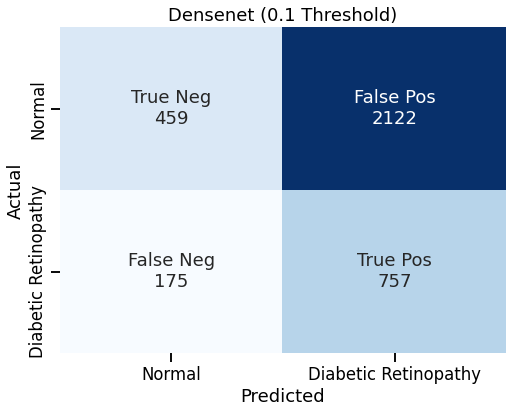

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Normal', 'Diabetic Retinopathy']

group_counts_1 = ['{0:0.0f}'.format(value) for value in cm.flatten()]
labels_1 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_1)]
labels_1 = np.asarray(labels_1).reshape(2,2)

sns.set_context('talk')
fig, ax= plt.subplots(figsize=(8,6))

sns.heatmap(cm, annot=labels_1, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
ax.set_ylabel('Actual')
ax.set_yticklabels(ax.get_yticklabels(), va="center")
ax.set_xlabel('Predicted')
ax.set_title('Densenet );

#plt.savefig('CM1.png')

In [ ]:
print(f'Recall:    {recall_score(test_reshaped, preds_best_densenet)}')
print(f'Precision: {precision_score(test_reshaped, preds_best_densenet)}')
print(f'Accuracy:  {accuracy_score(test_reshaped, preds_best_densenet)}')
print(f'F1 score:  {f1_score(test_reshaped, preds_best_densenet)}')
print(f'AUROC:     {roc_auc_score(test_reshaped, pred_transformed)}')

Recall:    0.1684549356223176
Precision: 0.24454828660436137
Accuracy:  0.64133219470538
F1 score:  0.19949174078780177
AUROC:     0.479408162654459


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# example of a roc curve for a predictive model
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot

## Model Ensembling

In [ ]:
import tensorflow.keras
import tensorflow as tf
from PIL import Image, ImageOps
import numpy as np


In [ ]:
load_file = '/content/gdrive/My Drive/Flatiron/models/densenet_ensemble_tuned.hdf5'
densenet_model = load_model(load_file)
#densenet_model.evaluate(test_ds)

In [ ]:
load_file = '/content/gdrive/My Drive/Flatiron/models/InceptionResNetV2_ensemble_tuned.hdf5'
irn_model = load_model(load_file)
#irn_model.evaluate(test_ds)

In [ ]:
load_file = '/content/gdrive/My Drive/Flatiron/models/Xception_ensemble_tuned.hdf5'
xception_model = load_model(load_file)
#xception_model.evaluate(test_ds)

In [ ]:
load_file = '/content/gdrive/My Drive/Flatiron/models/ResNet152V2_ensemble_tuned.hdf5'
resnet_model = load_model(load_file)
#resnet_model.evaluate(test_ds)

In [ ]:
keras_model = tensorflow.keras.models.load_model('/content/gdrive/My Drive/Flatiron/models/InceptionResNetV2_ensemble_tuned.hdf5', compile=False)
keras_model._name = 'model1'
keras_model2 = tensorflow.keras.models.load_model('/content/gdrive/My Drive/Flatiron/models/Xception_ensemble_tuned.hdf5', compile=False)
keras_model2._name = 'model2'
keras_model3 = tensorflow.keras.models.load_model('/content/gdrive/My Drive/Flatiron/models/densenet_ensemble_tuned.hdf5', compile=False)
keras_model3._name = 'model3'

In [ ]:
models = [keras_model, keras_model2, keras_model3]

model_input = tf.keras.Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)  


In [ ]:
ensemble_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model1 (Functional)            (None, 1)            54338273    ['input_16[0][0]']               
                                                                                                  
 model2 (Functional)            (None, 1)            20863529    ['input_16[0][0]']               
                                                                                                  
 model3 (Functional)            (None, 1)            18323905    ['input_16[0][0]']        

In [ ]:
models = [keras_model2, keras_model3]
model_input = tf.keras.Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model1 = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
models = [ensemble_model1, keras_model]
model_input = tf.keras.Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model2 = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
ensemble_model2.compile(
    optimizer=keras.optimizers.Adam(),  
    loss=keras.losses.BinaryCrossentropy(1e-5), 
    metrics=[keras.metrics.BinaryAccuracy()],
)


In [ ]:
ensemble_model2.evaluate(test_ds)

110/110 [==============================] - 47s 338ms/step - loss: 0.7225 - binary_accuracy: 0.8303


[0.7225264310836792, 0.8303444385528564]

In [ ]:
#ensemble_model.save('/content/gdrive/My Drive/Flatiron/models/basic_ensemble_model.hdf5')

In [ ]:
ensemble_model2.save('/content/gdrive/My Drive/Flatiron/models/best_ensemble_model.hdf5')

In [ ]:
pred = ensemble_model2.predict(test_ds)

In [ ]:
preds = np.where(pred>0.5, 1,0)

In [ ]:
cm  = confusion_matrix(test_reshaped, preds)

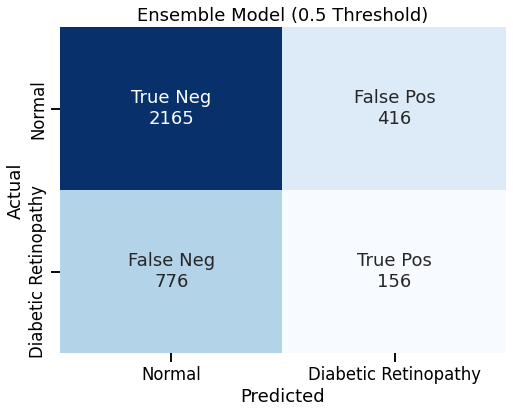

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Normal', 'Diabetic Retinopathy']

group_counts_1 = ['{0:0.0f}'.format(value) for value in cm.flatten()]
labels_1 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_1)]
labels_1 = np.asarray(labels_1).reshape(2,2)

sns.set_context('talk')
fig, ax= plt.subplots(figsize=(8,6))

sns.heatmap(cm, annot=labels_1, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
ax.set_ylabel('Actual')
ax.set_yticklabels(ax.get_yticklabels(), va="center")
ax.set_xlabel('Predicted')
ax.set_title('Ensemble Model (0.5 Threshold)');
plt.savefig('CMensemble2.png')

In [ ]:
print(f'Recall:    {recall_score(test_reshaped, preds)}')
print(f'Precision: {precision_score(test_reshaped, preds)}')
print(f'Accuracy:  {accuracy_score(test_reshaped, preds)}')
print(f'F1 score:  {f1_score(test_reshaped, preds)}')
print(f'AUROC:     {roc_auc_score(test_reshaped, pred)}')

Recall:    0.16738197424892703
Precision: 0.2727272727272727
Accuracy:  0.6606888699117563
F1 score:  0.2074468085106383
AUROC:     0.5120702958064296


#WEB DEMO

Web Demo was created and link can be found in the link below. Code for web app is also below. https://huggingface.co/spaces/DataDoggo/Visionary

In [ ]:
import requests
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras import datasets, layers, models

import pandas as pd
import numpy as np

import gradio as gr

load_file = 'densenet256x256_weighted_tuned.hdf5'
model=load_model(load_file)


img_resize = keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(256, 256, interpolation='bilinear')
    ]
)

def classify_image(inp):
    inp = img_resize(inp)
    img_array = keras.preprocessing.image.img_to_array(inp)
    img_array = tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array).flatten()
    return {'Probability of Diabetic Retinopathy:': float(np.exp(prediction)/(1+np.exp(prediction)))} #{labels[i]: float(prediction[i]) for i in range(1)}

content_image_input = gr.inputs.Image(label="Content Image")
style_image_input = gr.inputs.Image(shape=(256, 256), label="Style Image")

image = gr.inputs.Image(label = 'Image')
label = gr.outputs.Label(num_top_classes=1)

explanation = 'The first two sample images both have DR and the model confidently predicts it correctly. The next two images are examples without DR that the model confidently predicts correctly. The 5th image has DR, but the model guesses incorrectly. The 6th image does not have DR, but the model guesses incorrectly.'

gr.Interface(
    fn=classify_image,
    inputs= image,
    title = 'Prediction of Diabetic Retinopathy (DR)', 
    examples_per_page = 6,
    examples = ['DR100.jpeg', 'DR95.jpeg', 'Norm5.jpeg', 'Norm16.jpeg', 'DR8.jpeg', 'Norm95.jpeg' ],
    description = 'Demo for predicting the probability of having Diabetic Retinopathy. This version is currently using a DenseNet Model.',
    article = explanation,
    outputs=label,
    theme = "peach"
).launch()

#Conclusion

Out of all the models I built and hypertuned, the ensemble model had the best results. A diagram of it can be found below.

![models](https://drive.google.com/uc?export=view&id=1AMOBEh8NDJNQFGikJJxLbiY0s3Phsgrx)



![models](https://drive.google.com/uc?export=view&id=1AePHvxKc_Y8TglZKDx0SFoJmiYkbx0AN)


A Web demo was built based off our image classification model. This web demo was built so that users can easily take a picture on their phone and upload it through the predictive model. It can be found at: https://huggingface.co/spaces/DataDoggo/Visionary

**Future Recommendations**

*   With machine learning being accessible, we can train community health workers to use this technology.
*   This algorinthm can give us a prediction and based on this prediction we could make recommendations for patients to follow up with a physician.




**Next Steps**


*   Tabula data such as a patient's family history would go a long way.
*   Build the model to predict other eye diseases based off phone images.
*   Improve features on web applications such as providing physician recommendations.

